# 感知机 Perceptron

原理： 待补充

### 加载线性可分的数据集

导入库

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_classification

数据集生成函数

In [2]:
def generate_linearly_separable_data(n_samples=300, p=2, n_classes=3, class_sep=2.5, random_state=42):
    """
    生成一个 p 维、n_classes 类的线性可分数据集。

    参数说明：
    :param n_samples:    int，样本总数。
    :param p:            int，特征维度（每个样本的特征数）。
    :param n_classes:    int，类别数。
    :param class_sep:    float，类间距离，值越大类别越容易被线性区分。
    :param random_state: int，随机数种子，用于结果复现。

    返回值：
    :return:
        X: ndarray，形状为 [n_samples, p] 的特征矩阵。
        y: ndarray，形状为 [n_samples] 的标签向量，取值范围 {0, 1, ..., n_classes - 1}。
    """

    X, y = make_classification(
        n_samples=n_samples,
        n_features=p,
        n_informative=p,
        n_redundant=0,
        n_repeated=0,
        n_classes=n_classes,
        n_clusters_per_class=1,
        class_sep=class_sep,
        random_state=random_state
    )
    return X, y

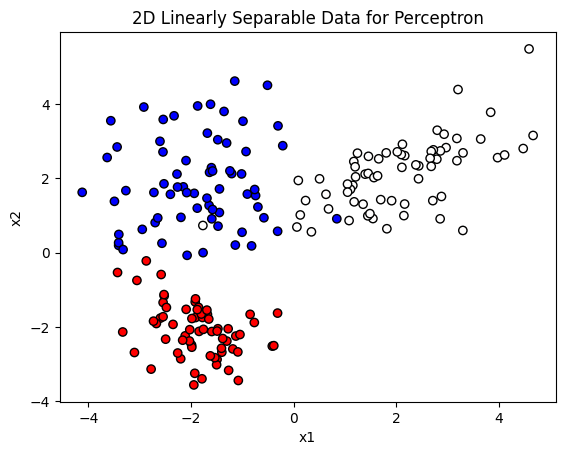

特征矩阵形状: (200, 2)
标签取值: [0 1 2]


In [3]:
p = 2  # 维度
X, y = generate_linearly_separable_data(n_samples=200, p=p, class_sep=2.0)

plt.scatter(X[:, 0], X[:, 1], c=y, cmap='bwr', edgecolor='k')
plt.title(f"{p}D Linearly Separable Data for Perceptron")
plt.xlabel("x1")
plt.ylabel("x2")
plt.show()

print("特征矩阵形状:", X.shape)
print("标签取值:", np.unique(y))

### 数据增广处理

In [4]:
def augmentation(X):
    """
    对 X 进行增广处理（在最后一列添加常数 1），以将偏置项 b 统一并入参数向量 W 中。
    :param X: 输入样本 [n_samples, p]
    :return: X: 增广样本 [n_samples, p + 1]
    """
    X_aug = np.hstack((X, np.ones((X.shape[0], 1))))
    return X_aug

In [5]:
# 输入：3 个样本，每个样本 2 个特征
X = np.array([
    [2.0, 3.0],
    [-1.0, 4.0],
    [0.0, -2.0]
])

X_aug = augmentation(X)
print("原始形状:", X.shape)
print("增广后形状:", X_aug.shape)
print("增广后矩阵:\n", X_aug)

原始形状: (3, 2)
增广后形状: (3, 3)
增广后矩阵:
 [[ 2.  3.  1.]
 [-1.  4.  1.]
 [ 0. -2.  1.]]


由于二分类任务与多分类任务存在区别，故对二分类进行特殊增强

In [6]:
def augmentation_for_two(X, y):
    """
    对 X 进行增广处理（在最后一列添加常数 1），以将偏置项 b 统一并入参数向量 W 中。
    :param X: 输入样本 [n_samples, p]
    :param y: 样本分类 [n_samples] y 属于 {-1, 1}
    :return: X: 增广样本 [n_samples, p + 1]
    """
    X_aug = np.hstack((X, np.ones((X.shape[0], 1)))) * y.reshape(-1, 1)
    return X_aug

In [7]:
# 输入：3 个样本，每个样本 2 个特征
X = np.array([
    [2.0, 3.0],
    [-1.0, 4.0],
    [0.0, -2.0]
])

y = np.array([1, -1, -1])

X_aug = augmentation_for_two(X, y)
print("原始形状:", X.shape)
print("增广后形状:", X_aug.shape)
print("增广后矩阵:\n", X_aug)

原始形状: (3, 2)
增广后形状: (3, 3)
增广后矩阵:
 [[ 2.  3.  1.]
 [ 1. -4. -1.]
 [-0.  2. -1.]]


### 初始化参数 W

In [8]:
def init_weights(n_classes, p, scale=0.01):
    """
    初始化各个线性判别函数参数
    :param scale: 参数修正系数
    :param n_classes: 类别数目
    :param p: 输入维度
    :return: 线性判别函数参数矩阵 W，为各个线性判别函数参数的行堆叠 [n_classes, p+1]
    """
    W = np.random.rand(n_classes, p + 1) * scale
    return W

In [9]:
n_classes = 3
p = 4

W = init_weights(n_classes, p)

print("权重矩阵 W：")
print(W)
print("\nW 的形状:", W.shape)

权重矩阵 W：
[[0.00559453 0.00093812 0.00880747 0.00706539 0.00639871]
 [0.00864922 0.00850594 0.0040956  0.00476516 0.00863919]
 [0.0015339  0.00879459 0.00474098 0.00804036 0.00618837]]

W 的形状: (3, 5)


### 训练过程(逐个样本计算)

多分类训练

In [18]:
def fit(X_aug, y, W, epoches = 100, learning_rate = 0.001, mode = "normal"):
    """
    感知机训练函数
    :param learning_rate: 学习率
    :param X_aug: 增广样本 [n_samples, p + 1]
    :param y: 样本实际类别 [n_samples]
    :param W: 权重矩阵 [n_classes, p + 1]
    :param epoches: 迭代次数
    :param mode: 迭代模式三种
    :return: 训练过程 W 列表 [W1, W2, ..., Wk]
    """
    W_list = [W.copy()]
    n_samples, p_plus = X_aug.shape
    n_classes = W.shape[0]
    
    for epoch in range(epoches):
        for j in range(len(y)):
            x = X_aug[j, :] # X_aug[j : j + 1, :]这样子是二维切片，现在这个切片方法是一维
            preds = np.matmul(x, W.T)
            y_true = y[j]
            y_pred = np.argmax(preds)

            if mode.lower() == "gpt":
                if y_pred != y_true:
                    W[y_pred, :] -= learning_rate * x
                    W[y_true, :] += learning_rate * x
            elif mode.lower() == "grad":
                # 目前梯度法实现二分类比较简单，多分类比较有难度，故暂且略过之后coming soon
                pass
            else:
                v = preds[y_true]
                error_pos = [i for i in range(preds.shape[0]) if (preds[i] >= v and i != y_true)]
                if len(error_pos) > 0:
                    W[error_pos, :] -= learning_rate * x
                    W[y_true, :] += learning_rate * x
                
        W_list.append(W.copy())
    
    return W_list

二分类训练

In [15]:
def fit_for_two(X_aug, y, W, epoches = 100, learning_rate = 0.001):
    """
    二分类感知机训练函数
    :param learning_rate: 学习率
    :param X_aug: 增广样本 [n_samples, p + 1]
    :param y: 样本实际类别 [n_samples]
    :param W: 权重矩阵 [1, p + 1]
    :param epoches: 迭代次数
    :return: 训练过程 W 列表 [W1, W2, ..., Wk]
    """
    W_list = [W.copy()]
    n_samples, p_plus = X_aug.shape
    n_classes = W.shape[0]
    
    for epoch in range(epoches):
        error = 0
        for j in range(len(y)):
            x = X_aug[j : j + 1, :] # X_aug[j : j + 1, :]这样子是二维切片，现在这个切片方法是一维
            pred = x @ W.T
            if pred <= 0:
                W += learning_rate * x
                error += 1
                W_list.append(W.copy())
        if error == 0:
            break
    
    return W_list

In [16]:
X = np.array([
    [0.0, 0.0, 0.0],
    [1.0, 0.0, 0.0],
    [1.0, 0.0, 1.0],
    [1.0, 1.0, 0.0],
    [0.0, 0.0, 1.0],
    [0.0, 1.0, 1.0],
    [0.0, 1.0, 0.0],
    [1.0, 1.0, 1.0],
])

y = np.array([1, 1, 1, 1, -1, -1, -1, -1])

X_aug = augmentation_for_two(X, y)

W = np.zeros((1, X_aug.shape[1]))
W_list = fit_for_two(X_aug, y, W, epoches = 100, learning_rate = 1)

print(W_list)

[array([[0., 0., 0., 0.]]), array([[0., 0., 0., 1.]]), array([[ 0.,  0., -1.,  0.]]), array([[ 0., -1., -1., -1.]]), array([[ 0., -1., -1.,  0.]]), array([[ 1., -1., -1.,  1.]]), array([[ 1., -1., -2.,  0.]]), array([[ 1., -1., -2.,  1.]]), array([[ 2., -1., -1.,  2.]]), array([[ 2., -1., -2.,  1.]]), array([[ 2., -2., -2.,  0.]]), array([[ 2., -2., -2.,  1.]])]


### 二维分类例子
为了方便可视化没有采用 `generate_linearly_separable_data()` 函数，而是人为地给出了三类区别较为明显的样本

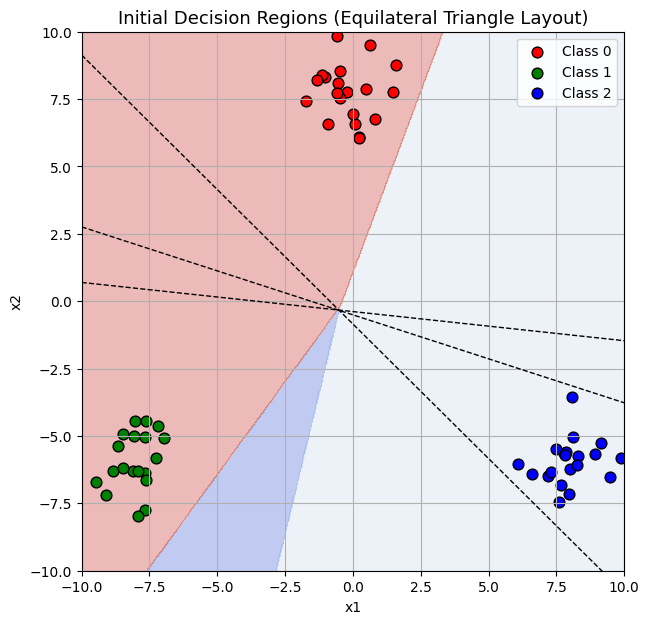

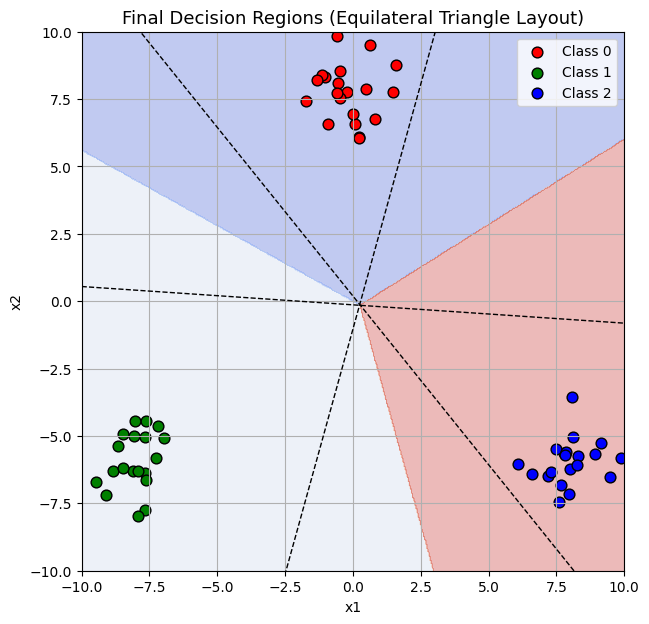

In [18]:
np.random.seed(42)

# 三个类别的中心：构成等边三角形（位于 [-10, 10] 范围内）
centers = np.array([
    [0, 8],      # 顶部类
    [-8, -6],    # 左下类
    [8, -6]      # 右下类
])

# 每类20个样本，带少量高斯噪声
X1 = np.random.randn(20, 2) * 1.0 + centers[0]
X2 = np.random.randn(20, 2) * 1.0 + centers[1]
X3 = np.random.randn(20, 2) * 1.0 + centers[2]

X = np.vstack([X1, X2, X3])
y = np.array([0]*20 + [1]*20 + [2]*20)

# ===== 增广样本与初始化权重 =====
X_aug = augmentation(X)
W_init = init_weights(3, X.shape[1])

# ===== 训练 =====
W_list = fit(X_aug, y, W_init, epoches=15, learning_rate=0.05, mode="normal")
W_final = W_list[-1]
W_init = W_list[0]

# ===== 绘图函数 =====
def plot_decision_region(W, class_points, title):
    x_min, x_max = -10, 10
    y_min, y_max = -10, 10
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 500),
                         np.linspace(y_min, y_max, 500))
    grid_aug = np.c_[xx.ravel(), yy.ravel(), np.ones(xx.size)]

    Z = np.argmax(grid_aug @ W.T, axis=1).reshape(xx.shape)

    plt.figure(figsize=(7,7))
    plt.contourf(xx, yy, Z, alpha=0.35, cmap='coolwarm')

    colors = ['r', 'g', 'b']
    for i, Xi in enumerate(class_points):
        plt.scatter(Xi[:,0], Xi[:,1], c=colors[i], edgecolor='k', s=60, label=f'Class {i}')

    # 判别线
    x_vals = np.linspace(x_min, x_max, 400)
    for i, w in enumerate(W):
        if w[1] != 0:
            y_vals = -(w[0]*x_vals + w[2]) / w[1]
            plt.plot(x_vals, y_vals, color='k', linestyle='--', linewidth=1)

    plt.title(title, fontsize=13)
    plt.xlabel("x1")
    plt.ylabel("x2")
    plt.legend()
    plt.grid(True)
    plt.xlim(x_min, x_max)
    plt.ylim(y_min, y_max)
    plt.show()

# ===== 绘制初始判别面 =====
plot_decision_region(W_init, [X1, X2, X3], "Initial Decision Regions (Equilateral Triangle Layout)")

# ===== 绘制最终判别面 =====
plot_decision_region(W_final, [X1, X2, X3], "Final Decision Regions (Equilateral Triangle Layout)")
